In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

forest = RandomForestRegressor()
lr = LinearRegression()
scaler = StandardScaler()

In [ ]:
df = pd.read_csv('Energy_consumption.csv')
df.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          1000 non-null   object 
 1   Temperature        1000 non-null   float64
 2   Humidity           1000 non-null   float64
 3   SquareFootage      1000 non-null   float64
 4   Occupancy          1000 non-null   int64  
 5   HVACUsage          1000 non-null   object 
 6   LightingUsage      1000 non-null   object 
 7   RenewableEnergy    1000 non-null   float64
 8   DayOfWeek          1000 non-null   object 
 9   Holiday            1000 non-null   object 
 10  EnergyConsumption  1000 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 86.1+ KB


In [ ]:
df.isnull().sum()

Timestamp            0
Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
DayOfWeek            0
Holiday              0
EnergyConsumption    0
dtype: int64

In [ ]:
numeric_df = df.select_dtypes(include=[np.number])

# Calculate correlation
correlation_matrix = numeric_df.corr()

In [ ]:
correlation_matrix

,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
Temperature,1.000000,-0.034032,0.004551,-0.003490,-0.001350,0.696410
Humidity,-0.034032,1.000000,-0.014651,0.004766,0.002052,-0.093583
SquareFootage,0.004551,-0.014651,1.000000,0.009696,0.022196,-0.001129
Occupancy,-0.003490,0.004766,0.009696,1.000000,0.013680,0.186580
RenewableEnergy,-0.001350,0.002052,0.022196,0.013680,1.000000,0.081160
EnergyConsumption,0.696410,-0.093583,-0.001129,0.186580,0.081160,1.000000


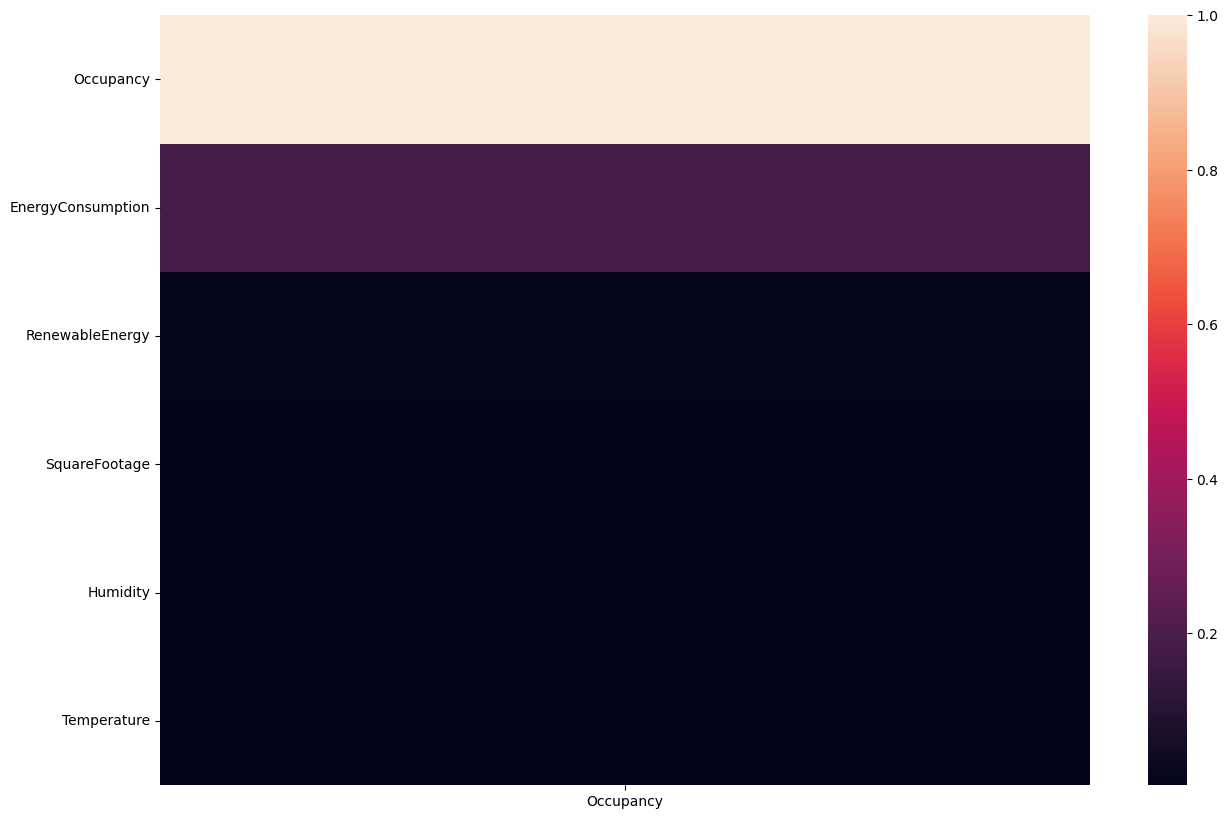

In [ ]:
import seaborn as sns
corr = abs(correlation_matrix)
snsheat_plot = sns.heatmap(corr[['Occupancy']].sort_values(by=['Occupancy'],ascending=False)).figure.set_size_inches(15, 10)

In [ ]:
df.describe()

,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,24.982026,45.395412,1500.052488,4.581000,15.132813,77.055873
std,2.836850,8.518905,288.418873,2.865598,8.745917,8.144112
min,20.007565,30.015975,1000.512661,0.000000,0.006642,53.263278
25%,22.645070,38.297722,1247.108548,2.000000,7.628385,71.544690
50%,24.751637,45.972116,1507.967426,5.000000,15.072296,76.943696
75%,27.418174,52.420066,1740.340165,7.000000,22.884064,82.921742
max,29.998671,59.969085,1999.982252,9.000000,29.965327,99.201120


<Axes: xlabel='EnergyConsumption'>

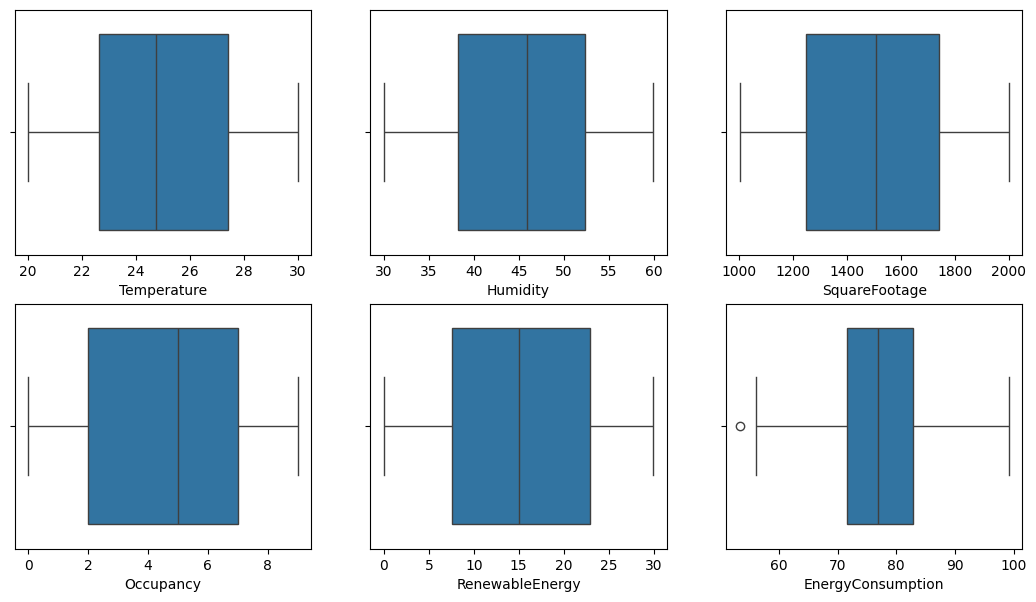

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(13, 7))

sns.boxplot(x=df['Temperature'], ax=axes[0][0])
sns.boxplot(x=df['Humidity'], ax=axes[0][1])
sns.boxplot(x=df['SquareFootage'], ax=axes[0][2])
sns.boxplot(x=df['Occupancy'], ax=axes[1][0])
sns.boxplot(x=df['RenewableEnergy'], ax=axes[1][1])
sns.boxplot(x=df['EnergyConsumption'], ax=axes[1][2])

In [ ]:
def total_outliers(column):
    column_df = pd.DataFrame(column)
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    IQR = q3 - q1
    outliers1 = column_df[(column_df<(q1-1.5*IQR)) | (column_df>(q3+1.5*IQR))]
    hasil = outliers1.count()
    return hasil

In [ ]:
total_outliers(df['EnergyConsumption'])

EnergyConsumption    1
dtype: int64

In [ ]:
df.drop(df[df['EnergyConsumption'] == df['EnergyConsumption'].min()].index, axis=0, inplace=True)

In [ ]:
df.drop(['Timestamp'], axis=1, inplace=True)
df = pd.get_dummies(df).astype(int)

df.head()

,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption,HVACUsage_Off,HVACUsage_On,LightingUsage_Off,LightingUsage_On,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Holiday_No,Holiday_Yes
0,25,43,1565,5,2,75,0,1,1,0,0,1,0,0,0,0,0,1,0
1,27,54,1411,1,21,83,0,1,0,1,0,0,1,0,0,0,0,1,0
2,28,58,1755,2,6,78,1,0,1,0,0,0,0,1,0,0,0,1,0
3,20,50,1452,1,8,56,1,0,0,1,0,0,0,0,0,0,1,1,0
4,23,51,1094,9,3,70,0,1,1,0,1,0,0,0,0,0,0,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 0 to 999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Temperature          999 non-null    int64
 1   Humidity             999 non-null    int64
 2   SquareFootage        999 non-null    int64
 3   Occupancy            999 non-null    int64
 4   RenewableEnergy      999 non-null    int64
 5   EnergyConsumption    999 non-null    int64
 6   HVACUsage_Off        999 non-null    int64
 7   HVACUsage_On         999 non-null    int64
 8   LightingUsage_Off    999 non-null    int64
 9   LightingUsage_On     999 non-null    int64
 10  DayOfWeek_Friday     999 non-null    int64
 11  DayOfWeek_Monday     999 non-null    int64
 12  DayOfWeek_Saturday   999 non-null    int64
 13  DayOfWeek_Sunday     999 non-null    int64
 14  DayOfWeek_Thursday   999 non-null    int64
 15  DayOfWeek_Tuesday    999 non-null    int64
 16  DayOfWeek_Wednesday  999 non-nu

#Forecasting

## Linear Regression

In [ ]:
X = df.drop('EnergyConsumption', axis=1)
y = df['EnergyConsumption']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

In [ ]:

lr.fit(X_train, y_train)
mse_lr = mean_squared_error(y_test, lr.predict(X_test))
r2_lr = r2_score(y_test, lr.predict(X_test))
mae_lr = mean_absolute_error(y_test, lr.predict(X_test))

print(f'MSE Score on Test set: {mse_lr:0.2f}')
print(f'RMSE Score on Test set: {np.sqrt(mse_lr):0.2f}')
print(f'R2 Score on Test set: {r2_lr:0.2f}')
print(f'MAE Score on Test set: {mae_lr:0.2f}')

MSE Score on Test set: 24.89
RMSE Score on Test set: 4.99
R2 Score on Test set: 0.62
MAE Score on Test set: 4.06


In [ ]:
lr.score(X_test, y_test)

0.6215262876526415

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Define the hyperparameters grid
param_grid = {
    'lr__fit_intercept': [True, False],
    'lr__copy_X': [True, False],          # Whether to copy the input features
    'lr__n_jobs': [-1, 1, None],
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model
mse_lr_best = mean_squared_error(y_test, best_model.predict(X_test))
r2_lr_best = r2_score(y_test, best_model.predict(X_test))
mae_lr_best = mean_absolute_error(y_test, best_model.predict(X_test))

print("Best Hyperparameters:", grid_search.best_params_)
print(f'MSE Score on Test set with Hyperparameter Optimization: {mse_lr_best:0.2f}')
print(f'RMSE Score on Test set with Hyperparameter Optimization: {np.sqrt(mse_lr_best):0.2f}')
print(f'R2 Score on Test set with Hyperparameter Optimization: {r2_lr_best:0.2f}')
print(f'MAE Score on Test set with Hyperparameter Optimization: {mae_lr_best:0.2f}')

Best Hyperparameters: {'lr__copy_X': True, 'lr__fit_intercept': True, 'lr__n_jobs': -1}
MSE Score on Test set with Hyperparameter Optimization: 24.89
RMSE Score on Test set with Hyperparameter Optimization: 4.99
R2 Score on Test set with Hyperparameter Optimization: 0.62
MAE Score on Test set with Hyperparameter Optimization: 4.06


## Random Forest

In [ ]:
forest.fit(X_train, y_train)
forest_mse= mean_squared_error(y_test, forest.predict(X_test))
forest_r2 = r2_score(y_test, forest.predict(X_test))
forest_mae = mean_absolute_error (y_test, forest.predict(X_test))

print(f'MSE Score on Test set: {forest_mse:0.2f}')
print(f'RMSE Score on Test set: {np.sqrt(forest_mse):0.2f}')
print(f'R2 Score on Test set: {forest_r2:0.2f}')
print(f'MAE Score on Test set: {forest_mae:0.2f}')

MSE Score on Test set: 27.56
RMSE Score on Test set: 5.25
R2 Score on Test set: 0.58
MAE Score on Test set: 4.16


In [ ]:
forest2 = RandomForestRegressor()

param_grid = {
    'max_depth' : [5,10,15,20, None],
    'max_features' : ['sqrt', 'log2'],
    'n_estimators' : [50, 100, 200, 300, 500],
    'min_samples_split' : [2, 5, 10, 15, 20],

}

forest2 = GridSearchCV(estimator=forest2, param_grid=param_grid)
forest2.fit(X_train, y_train)

forest2.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 500}

In [ ]:
f3 = RandomForestRegressor(max_features = 'sqrt', max_depth = None, n_estimators = 500, min_samples_split = 2)
f3.fit(X_train, y_train)

mse_f3 = mean_squared_error(y_test, f3.predict(X_test))
r2_f3 = r2_score(y_test, f3.predict(X_test))
mae_f3 = mean_absolute_error (y_test, f3.predict(X_test))
rmse_f3 = np.sqrt(mse_f3)

print(f'MSE Score on Test set: {mse_f3:0.2f}')
print(f'RMSE Score on Test set: {rmse_f3:0.2f}')
print(f'R2 Score on Test set: {r2_f3:0.2f}')
print(f'MAE Score on Test set: {mae_f3:0.2f}')

MSE Score on Test set: 27.14
RMSE Score on Test set: 5.21
R2 Score on Test set: 0.59
MAE Score on Test set: 4.16


In [ ]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.2 MB/s eta 0:00:00


In [ ]:
from skopt import BayesSearchCV


# Define the parameter search space
param_space = {
    'n_estimators': (100, 500),
    'max_depth': (1, 20),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Perform Bayesian optimization with 5-fold cross-validation
opt = BayesSearchCV(
    forest,
    param_space,
    n_iter=50,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Fit the optimizer to the training data
opt.fit(X_train, y_train)

# Get the best estimator
best_forest_model = opt.best_estimator_

# Evaluate the best model
forest_mse_best = mean_squared_error(y_test, best_forest_model.predict(X_test))
forest_r2_best = r2_score(y_test, best_forest_model.predict(X_test))
forest_mae_best = mean_absolute_error(y_test, best_forest_model.predict(X_test))

print("Best Hyperparameters:", opt.best_params_)
print(f'MSE Score on Test set with Hyperparameter Optimization: {forest_mse_best:0.2f}')
print(f'R2 Score on Test set with Hyperparameter Optimization: {forest_r2_best:0.2f}')
print(f'MAE Score on Test set with Hyperparameter Optimization: {forest_mae_best:0.2f}')


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [20, 'auto', 10, 10, 500] before, using random point [20, 'auto', 1, 8, 286]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [20, 'auto', 10, 10, 500] before, using random point [10, 'auto', 3, 9, 217]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [20, 'auto', 10, 10, 500] before, using random point [14, 'sqrt', 2, 9, 384]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [20, 'auto', 10, 10, 500] before, using random point [9, 'sqrt', 10, 6, 341]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has bee

Best Hyperparameters: OrderedDict([('max_depth', 12), ('max_features', 'auto'), ('min_samples_leaf', 10), ('min_samples_split', 10), ('n_estimators', 500)])
MSE Score on Test set with Hyperparameter Optimization: 26.11
R2 Score on Test set with Hyperparameter Optimization: 0.60
MAE Score on Test set with Hyperparameter Optimization: 4.07


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor



# Define the hyperparameters grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required at each leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider when looking for the best split
}

# Perform RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(forest, param_distributions=param_grid, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

# Get the best model
best_forest_model = random_search.best_estimator_

# Evaluate the best model
forest_mse_best = mean_squared_error(y_test, best_forest_model.predict(X_test))
forest_r2_best = r2_score(y_test, best_forest_model.predict(X_test))
forest_mae_best = mean_absolute_error(y_test, best_forest_model.predict(X_test))

print("Best Hyperparameters:", random_search.best_params_)
print(f'MSE Score on Test set with Hyperparameter Optimization: {forest_mse_best:0.2f}')
print(f'RMSE Score on Test set with Hyperparameter Optimization: {np.sqrt(forest_mse_best):0.2f}')
print(f'R2 Score on Test set with Hyperparameter Optimization: {forest_r2_best:0.2f}')
print(f'MAE Score on Test set with Hyperparameter Optimization: {forest_mae_best:0.2f}')


Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': None}
MSE Score on Test set with Hyperparameter Optimization: 25.94
RMSE Score on Test set with Hyperparameter Optimization: 5.09
R2 Score on Test set with Hyperparameter Optimization: 0.61
MAE Score on Test set with Hyperparameter Optimization: 4.03




---



In [ ]:
# Get feature importances
feature_importances = forest.feature_importances_

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Select top features based on importance
num_top_features = 5  # Adjust this number as needed
top_features = feature_importance_df['Feature'][:num_top_features]


In [ ]:
from sklearn.feature_selection import SelectFromModel

# Train the RandomForestRegressor model
forest = RandomForestRegressor()
forest.fit(X_train, y_train)

# Define the feature selection model with a fitted estimator
feature_selection_model = SelectFromModel(forest, threshold='mean', prefit=True)

# Transform the training and test data using the feature selection model
X_train_selected = feature_selection_model.transform(X_train)
X_test_selected = feature_selection_model.transform(X_test)

# Get selected feature indices
selected_feature_indices = feature_selection_model.get_support(indices=True)

# Get selected feature names
selected_feature_names = X_train.columns[selected_feature_indices]

# Define the hyperparameters grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required at each leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider when looking for the best split
}

# Perform RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(forest, param_distributions=param_grid, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train_selected, y_train)

# Get the best model
best_forest_model = random_search.best_estimator_

# Evaluate the best model
forest_mse_best = mean_squared_error(y_test, best_forest_model.predict(X_test_selected))
forest_r2_best = r2_score(y_test, best_forest_model.predict(X_test_selected))
forest_mae_best = mean_absolute_error(y_test, best_forest_model.predict(X_test_selected))

print("Best Hyperparameters:", random_search.best_params_)
print(f'MSE Score on Test set with Hyperparameter Optimization and Feature Selection: {forest_mse_best:0.2f}')
print(f'RMSE Score on Test set with Hyperparameter Optimization and Feature Selection: {np.sqrt(forest_mse_best):0.2f}')
print(f'R2 Score on Test set with Hyperparameter Optimization and Feature Selection: {forest_r2_best:0.2f}')
print(f'MAE Score on Test set with Hyperparameter Optimization and Feature Selection: {forest_mae_best:0.2f}')

# Set the selected feature names
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_feature_names)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_feature_names)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None}
MSE Score on Test set with Hyperparameter Optimization and Feature Selection: 39.27
RMSE Score on Test set with Hyperparameter Optimization and Feature Selection: 6.27
R2 Score on Test set with Hyperparameter Optimization and Feature Selection: 0.47
MAE Score on Test set with Hyperparameter Optimization and Feature Selection: 5.01


##XGBoost


In [ ]:
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train)

mse_reg = mean_squared_error(y_test, reg.predict(X_test))
r2_reg = r2_score(y_test, reg.predict(X_test))
mae_reg = mean_absolute_error (y_test, reg.predict(X_test))

print(f'MSE Score on Test set: {mse_reg:0.2f}')
print(f'RMSE Score on Test set: {np.sqrt(mse_reg):0.2f}')
print(f'R2 Score on Test set: {r2_reg:0.2f}')
print(f'MAE Score on Test set: {mae_reg:0.2f}')

MSE Score on Test set: 30.34
RMSE Score on Test set: 5.51
R2 Score on Test set: 0.54
MAE Score on Test set: 4.51


In [ ]:
from sklearn.model_selection import GridSearchCV

reg2 = xgb.XGBRegressor()

param_grid = {
    'max_depth' : [4,5,6,7,8,10],
    'n_estimators' : [50,100, 200,300,500],
    'learning_rate' : [0.01,0.05,0.1,0.2],
    'min_child_weight' : [10,20,30,40,50,100],}

reg2 = GridSearchCV(estimator=reg2, param_grid=param_grid)

reg2.fit(X_train, y_train)

reg2.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 100,
 'n_estimators': 50}

In [ ]:
reg3 = xgb.XGBRegressor(min_child_weight = 100,
                        learning_rate = 0.1,
                        max_depth = 4, n_estimators = 50)
reg3.fit(X_train, y_train)

mse_reg3 = mean_squared_error(y_test, reg3.predict(X_test))
r2_reg3 = r2_score(y_test, reg3.predict(X_test))
mae_reg3 = mean_absolute_error (y_test, reg3.predict(X_test))
rmse_reg3 = np.sqrt(mse_reg3)

print(f'MSE Score on Test set: {mse_reg3:0.2f}')
print(f'RMSE Score on Test set: {rmse_reg3:0.2f}')
print(f'R2 Score on Test set: {r2_reg3:0.2f}')
print(f'MAE Score on Test set: {mae_reg3:0.2f}')

MSE Score on Test set: 26.35
RMSE Score on Test set: 5.13
R2 Score on Test set: 0.60
MAE Score on Test set: 4.16




---



##CodeCarbon

In [ ]:
!pip install codecarbon


  Using cached codecarbon-2.3.5-py3-none-any.whl (174 kB)
  Using cached arrow-1.3.0-py3-none-any.whl (66 kB)
  Using cached pynvml-11.5.0-py3-none-any.whl (53 kB)
  Using cached rapidfuzz-3.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.4 MB)
  Using cached types_python_dateutil-2.9.0.20240316-py3-none-any.whl (9.7 kB)


In [ ]:
!pip install --upgrade codecarbon


In [ ]:
pip show codecarbon

Name: codecarbon
Version: 2.3.5
Summary: 
Home-page: 
Author: Mila, DataForGood, BCG GAMMA, Comet.ml, Haverford College
Author-email: 
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: arrow, click, pandas, prometheus-client, psutil, py-cpuinfo, pynvml, rapidfuzz, requests
Required-by: 


In [ ]:
import codecarbon
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Sample data (replace with your actual data)
df = pd.DataFrame({'Feature1': [1, 2, 3, 4], 'Feature2': [5, 6, 7, 8], 'EnergyConsumption': [9, 10, 11, 12]})

# Separate features and target variable
X = df.drop('EnergyConsumption', axis=1)
y = df['EnergyConsumption']

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize features (optional, but recommended for XGBoost)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Upgrade codecarbon (if necessary)
#!pip install --upgrade codecarbon

# Track emissions with CodeCarbon (online mode requires internet connection)
print("**Note:** Online mode requires internet connection during code execution.")
with codecarbon.EmissionsTracker() as tracker:
    # Train XGBoost model (consider reducing hyperparameter search space for faster execution in Colab)
    reg2 = XGBRegressor()

    param_grid = {
        'max_depth': [4, 5, 6],  # Reduce hyperparameter search space for faster execution in Colab
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_weight': [10, 20, 30],
    }

    # Adjust cv parameter to a value less than or equal to the number of training samples (3 in this case)
    reg2 = GridSearchCV(estimator=reg2, param_grid=param_grid, cv=2)  # Example with cv=2
    reg2.fit(X_train_s, y_train)

    # Evaluate model performance
    mse_reg3 = mean_squared_error(y_test, reg2.best_estimator_.predict(X_test_s))
    r2_reg3 = r2_score(y_test, reg2.best_estimator_.predict(X_test_s))
    mae_reg3 = mean_absolute_error(y_test, reg2.best_estimator_.predict(X_test_s))
    rmse_reg3 = np.sqrt(mse_reg3)

    print("Model performance metrics:")
    print(f"MSE: {mse_reg3:.4f}")
    print(f"R-squared: {r2_reg3:.4f}")
    print(f"MAE: {mae_reg3:.4f}")
    print(f"RMSE: {rmse_reg3:.4f}")

    # Print estimated CO2 emissions (assuming successful online tracking)
    print("Estimated CO2 emissions for model training and testing:", tracker.footprint)  # Updated attribute name


[codecarbon INFO @ 18:00:08] [setup] RAM Tracking...
[codecarbon INFO @ 18:00:08] [setup] GPU Tracking...
[codecarbon INFO @ 18:00:08] No GPU found.
[codecarbon INFO @ 18:00:08] [setup] CPU Tracking...
[codecarbon WARNING @ 18:00:08] No CPU tracking mode found. Falling back on CPU constant mode.


**Note:** Online mode requires internet connection during code execution.


[codecarbon WARNING @ 18:00:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 18:00:09] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 18:00:09] >>> Tracker's metadata:
[codecarbon INFO @ 18:00:09]   Platform system: Linux-6.1.58+-x86_64-with-glibc2.35
[codecarbon INFO @ 18:00:09]   Python version: 3.10.12
[codecarbon INFO @ 18:00:09]   CodeCarbon version: 2.3.5
[codecarbon INFO @ 18:00:09]   Available RAM : 12.675 GB
[codecarbon INFO @ 18:00:09]   CPU count: 2
[codecarbon INFO @ 18:00:09]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 18:00:09]   GPU count: None
[codecarbon INFO @ 18:00:09]   GPU model: None
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metri

Model performance metrics:
MSE: 4.0000
R-squared: nan
MAE: 2.0000
RMSE: 2.0000


AttributeError: 'EmissionsTracker' object has no attribute 'footprint'

In [ ]:
col = np.array(X_train.columns)
imp = np.array(f3.feature_importances_)

df_imp = pd.DataFrame({'columns': col, 'importance': imp}, columns=['columns', 'importance'])
df_imp.sort_values('importance', ascending = False)

,columns,importance
0,Temperature,0.403427
2,SquareFootage,0.102886
4,RenewableEnergy,0.092722
1,Humidity,0.091347
3,Occupancy,0.088634
5,HVACUsage_Off,0.039672
6,HVACUsage_On,0.037260
8,LightingUsage_On,0.015263
7,LightingUsage_Off,0.014330
15,DayOfWeek_Wednesday,0.013416


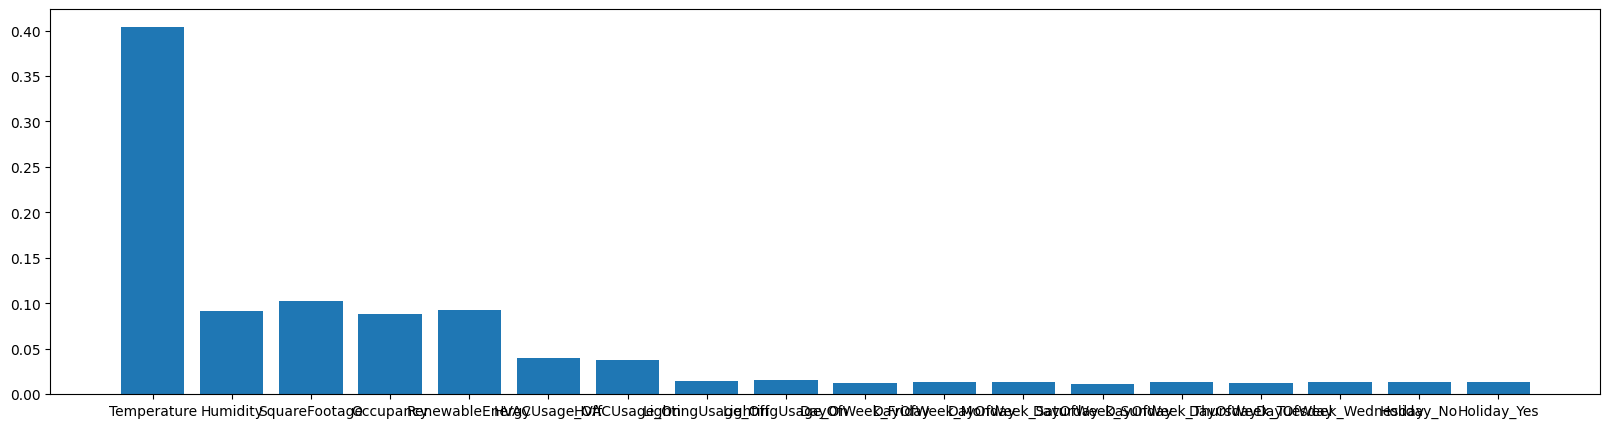

In [ ]:
fig = plt.figure(figsize = (20, 5))
plt.bar(X_train.columns, f3.feature_importances_)
plt.show()

In [ ]:
def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):

    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=30)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=30)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=30)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

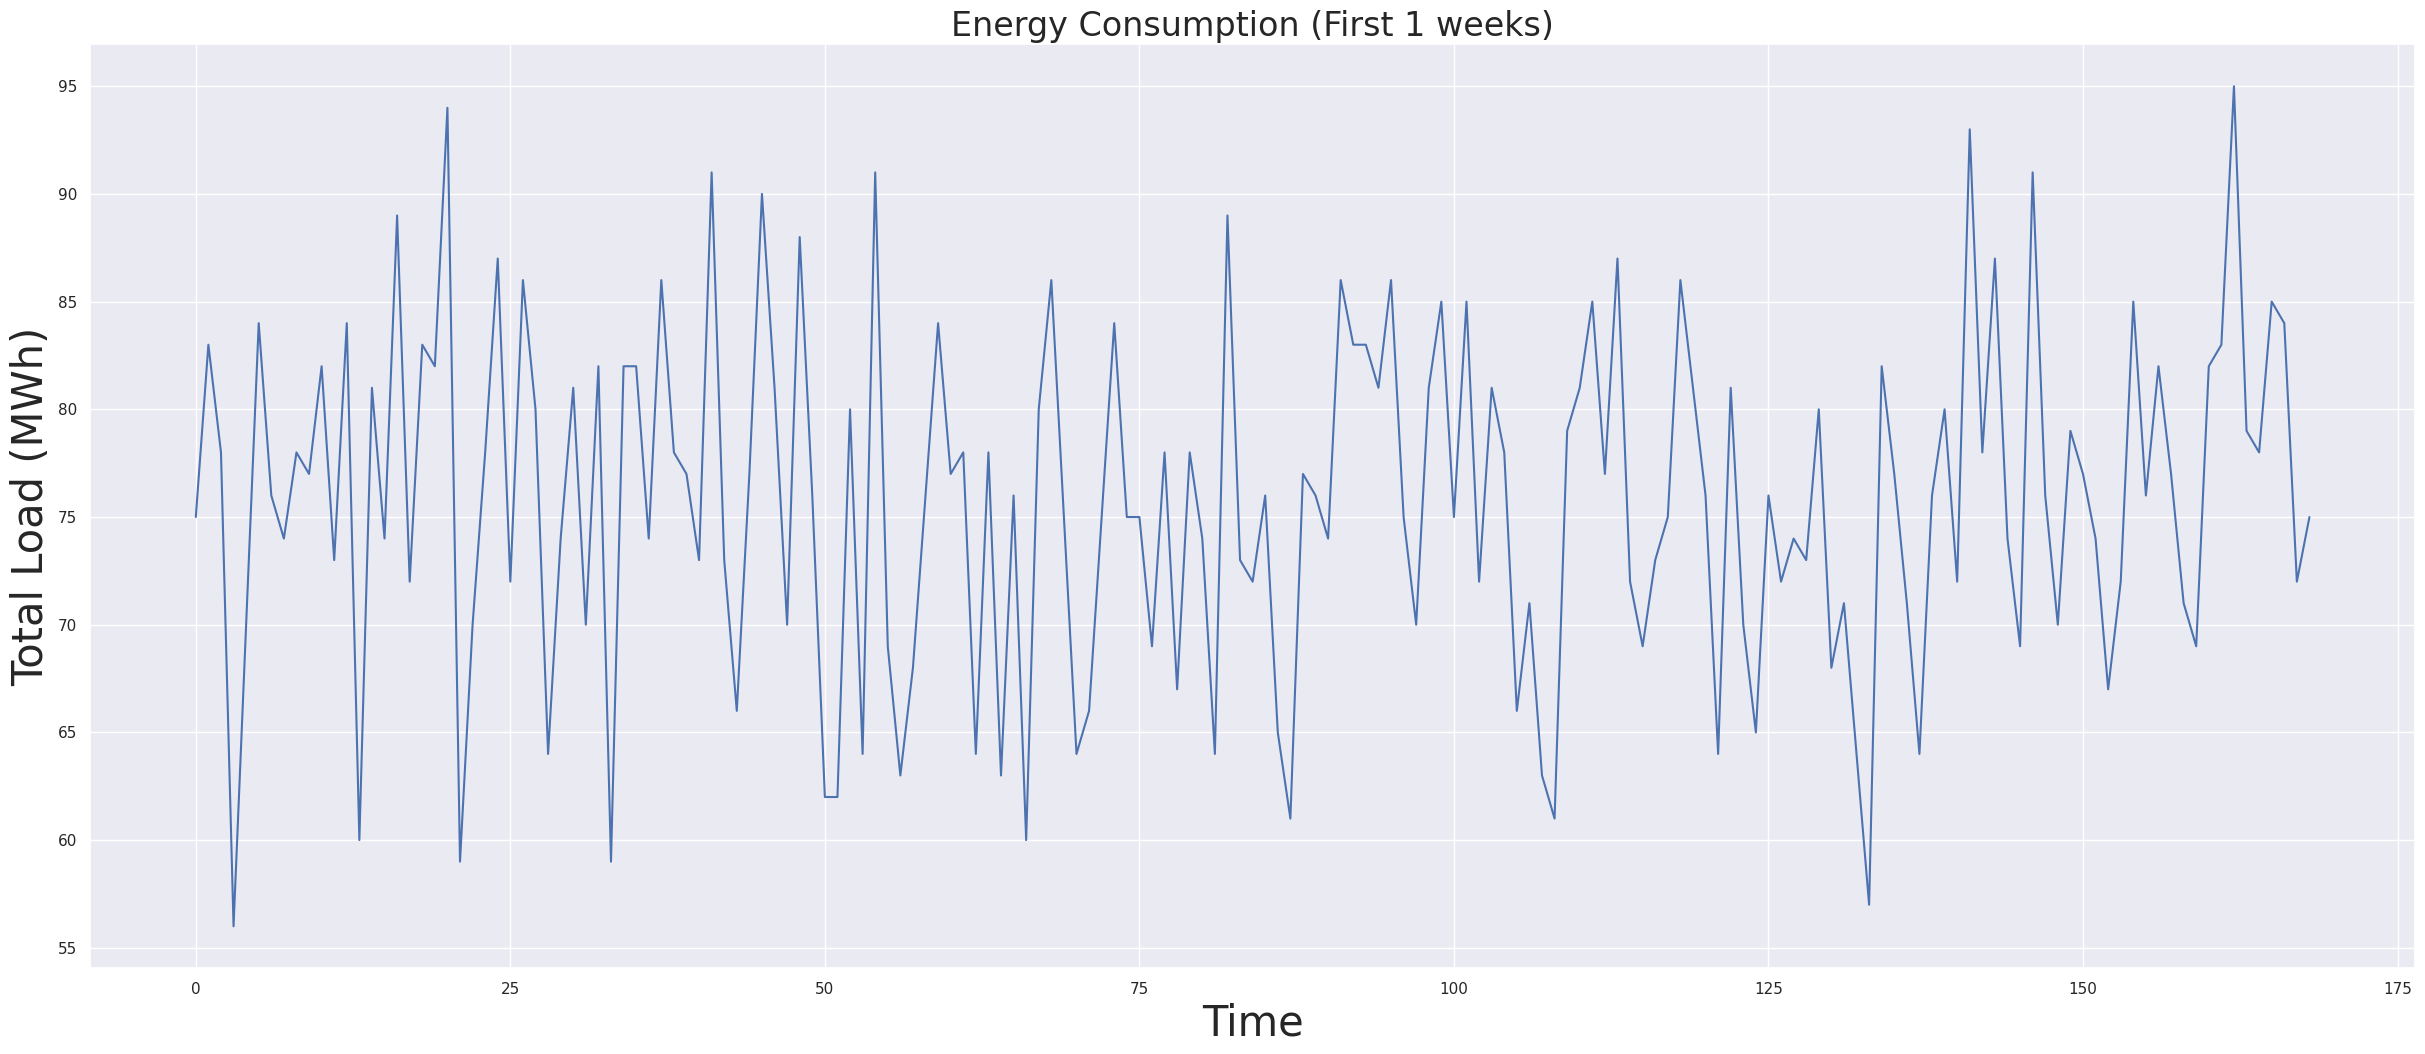

In [ ]:
ax = plot_series(df, column='EnergyConsumption', ylabel='Total Load (MWh)',
                 title='Energy Consumption (First 1 weeks)', end=24*7)
plt.show()

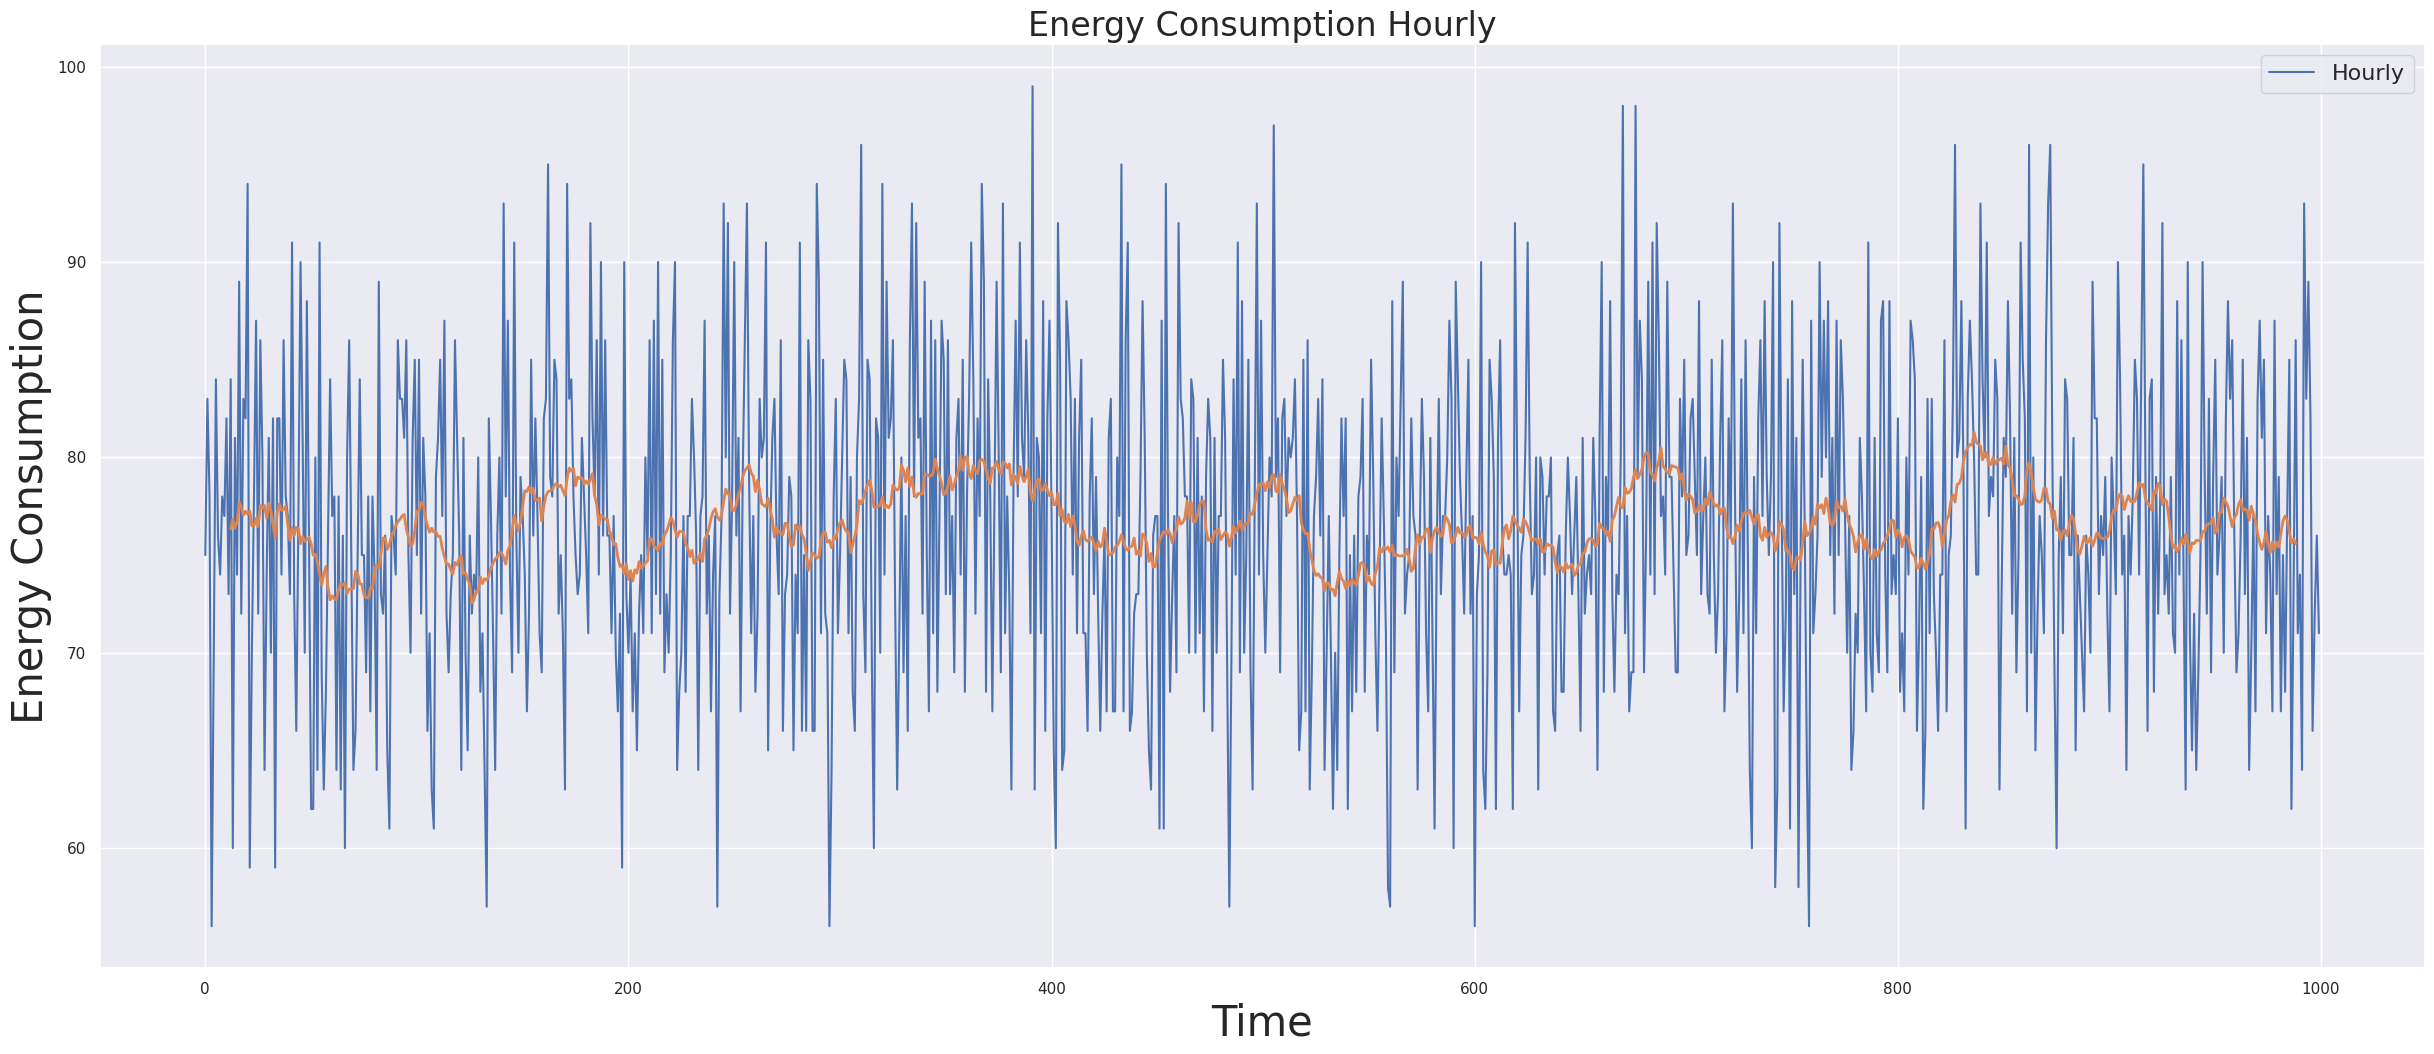

In [ ]:
# Plot the hourly Energy Consumption, along with the weekly rolling mean
rolling = df['EnergyConsumption'].rolling(24, center=True).mean()
ax = plot_series(df, 'EnergyConsumption', label='Hourly', ylabel='Energy Consumption',
                 title='Energy Consumption Hourly')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

In [ ]:
def show_raw_visualization(data, nrows, width, height):
    #time_data1 = data.index
    fig, axes = plt.subplots(
        nrows=nrows, ncols=2, figsize=(width, height), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = data.index
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(key, titles[i]),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()

In [ ]:
colors = ["blue", "orange", "green", "red"]
titles = [ 'Temperature', 'Humidity', 'EnergyConsumption', 'RenewableEnergy']

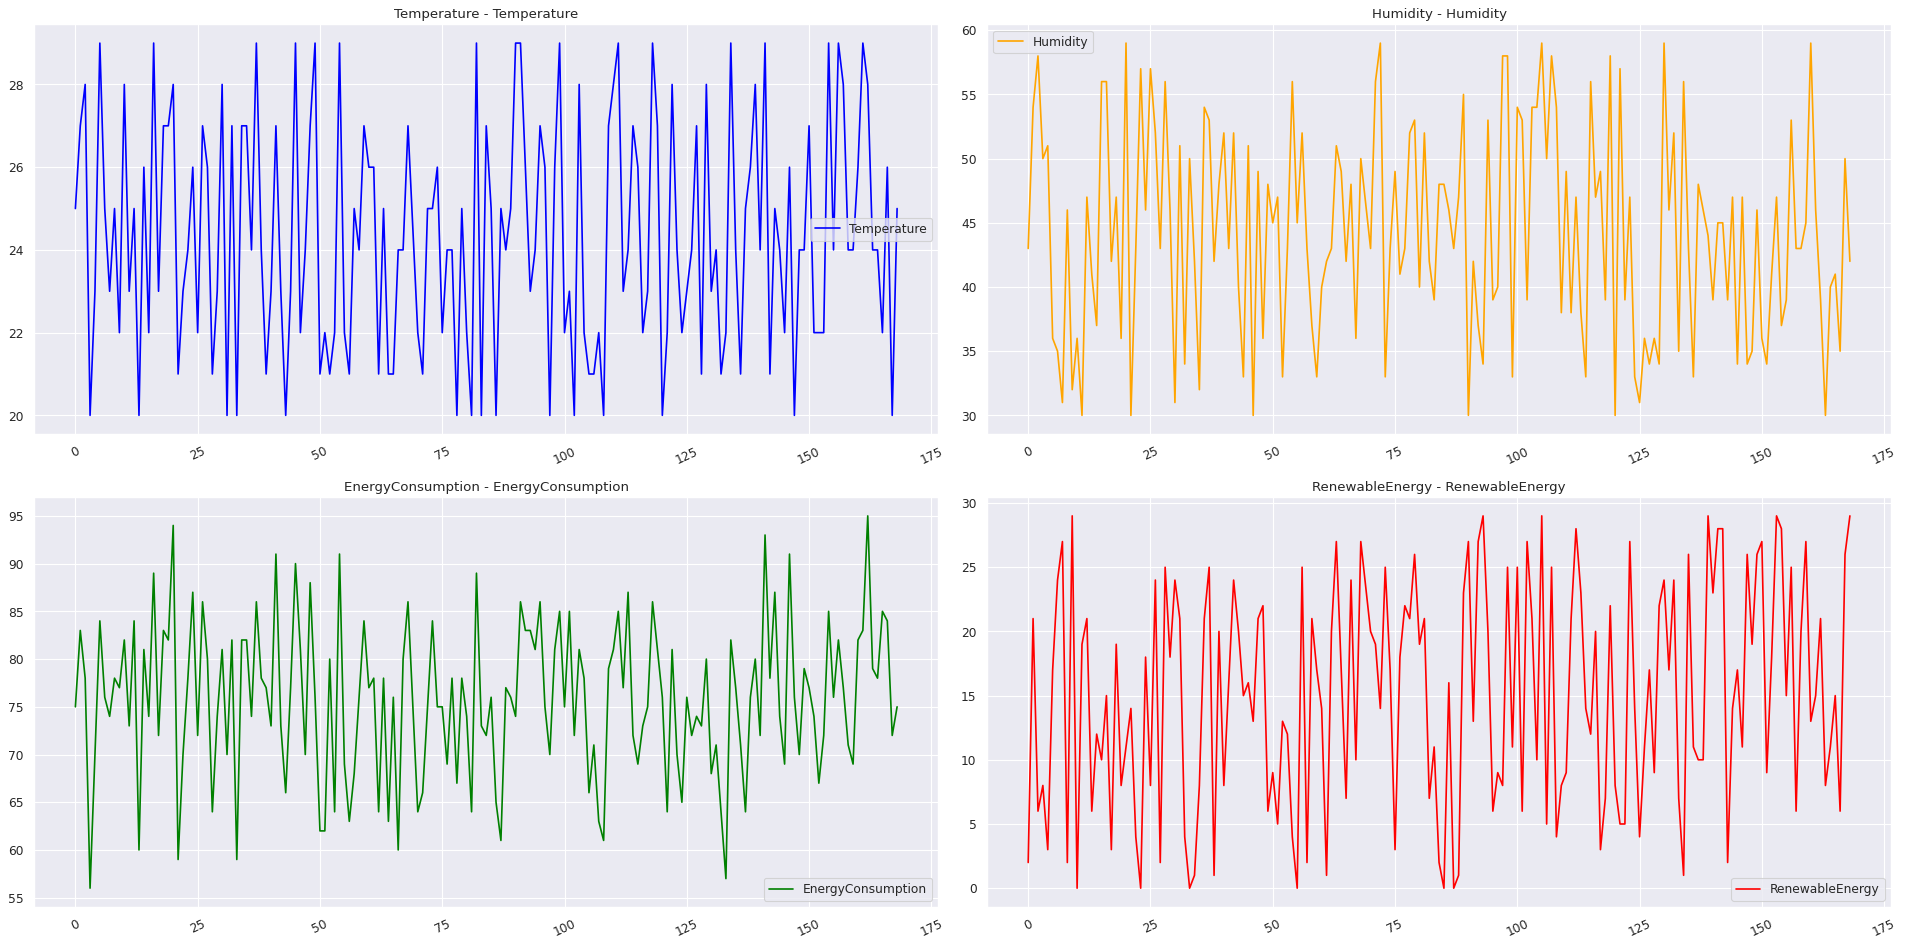

In [ ]:
feature_keys = ['Temperature', 'Humidity', 'EnergyConsumption', 'RenewableEnergy']
show_raw_visualization(df[:24*7],nrows=2,width=24,height=12)

In [ ]:
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
from sklearn.linear_model import Ridge
model_rg = Ridge().fit(X_train, y_train)

print('Intercept:', np.round(model_rg.intercept_,3))

Intercept: 26.599


In [ ]:
model_rg.coef_

array([ 2.02590064e+00, -4.57590433e-02, -6.27961606e-04,  5.25126783e-01,
        7.33575007e-02, -2.30262744e+00,  2.30262744e+00, -9.74024015e-01,
        9.74024015e-01, -4.36514420e-03, -3.57874297e-01, -9.77161333e-02,
        1.00932081e-01,  7.04529439e-01, -9.87428569e-02, -2.46763089e-01,
       -1.46101018e-01,  1.46101018e-01])

In [ ]:
rg_pred = model_rg.predict(X_test)

In [ ]:
print(r2_score(y_test, rg_pred))

0.6079792672940156


In [ ]:
param = {
    'alpha':[0.001,0.01, 0.01,1],
    'fit_intercept':[True,False],
    'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
       }

In [ ]:
model = Ridge()
search = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=cv)

result = search.fit(X, y)
print('Best Hyperparameters: %s' % result.best_params_)

Best Hyperparameters: {'alpha': 1, 'fit_intercept': True, 'solver': 'lsqr'}


In [ ]:
model = Ridge(alpha=1,fit_intercept= True, solver ='lsqr')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(r2_score(y_test,y_pred))

0.6137495745599688


## CodeCarbon

In [ ]:
pip install codecarbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.6/174.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.3 MB/s eta 0:00:00


In [ ]:
import joblib
from codecarbon import EmissionsTracker

# Load the trained models
reg2 = joblib.load("random_forest_model.pkl")
xgb_model = joblib.load("xgboost_model.pkl")
lr_model = joblib.load("linear_regression_model.pkl")

# Load the test data
X_test = ...  # Load your test data here
y_test = ...  # Load your test data labels here

# Initialize CodeCarbon's EmissionsTracker
tracker = EmissionsTracker()

# Track emissions for Random Forest model predictions
with tracker.emissions_tracker():
    rf_predictions = rf_model.predict(X_test)

# Track emissions for XGBoost model predictions
with tracker.emissions_tracker():
    xgb_predictions = xgb_model.predict(X_test)

# Track emissions for Linear Regression model predictions
with tracker.emissions_tracker():
    lr_predictions = lr_model.predict(X_test)

# Print emissions for each model
print("Random Forest Emissions (kgCO2):", tracker.get_emissions(rf_predictions))
print("XGBoost Emissions (kgCO2):", tracker.get_emissions(xgb_predictions))
print("Linear Regression Emissions (kgCO2):", tracker.get_emissions(lr_predictions))
